# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [90]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import torch
import numpy as np
import math
import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import keras.backend as K
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
import cv2
from sklearn.metrics import roc_auc_score, f1_score


# Google Drive Connect



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data loading

In [95]:
# Load train and test splits.
data = pd.read_csv("/content/drive/MyDrive/ECE1512ProjA/annotations.csv")
data.head()

,Image,Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


In [99]:
Train = []
Tlabel = []#1 for SSA,0 for HP
Val = []
Vlabel = []
for i,p in enumerate(data.Partition):
  img = cv2.imread("/content/drive/MyDrive/ECE1512ProjA/images/" + data.Image[i])
  label = 1 if data.Label[i] == "SSA" else 0
  #print(label,data.Label[i])
  if p == "train":
    Train.append(img)
    Tlabel.append(label)
  else:
    Val.append(img)
    Vlabel.append(label)

In [100]:
#Flip=
length = len(Train)
for i in range(length):
  IMG = np.fliplr(Train[i])
  Train.append(IMG)
  Tlabel.append(Tlabel[i])

In [101]:
#Rotate
length = len(Train)
for i in range(length):
  Train.append(np.rot90(Train[i],1))
  Tlabel.append(Tlabel[i])

In [102]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.labels = labels

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        # print(index)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = ID
            y[i] = self.labels[i]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [103]:
TRAIN= DataGenerator(Train,Tlabel)
Val= DataGenerator(Val,Vlabel)

# Model creation

In [113]:
def teacher():
  base_teacher = tf.keras.applications.resnet_v2.ResNet50V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
  imgs = base_teacher.input
  midput = base_teacher(imgs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  midput = keras.layers.GlobalMaxPooling2D()(midput)
  midput = keras.layers.Dropout(0.5)(midput)
  outputs = Dense(2)(midput)
  teacher_model = keras.Model(imgs, outputs)
  return base_teacher,teacher_model

def student():
  base_student = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
  simgs = base_student.input
  smidput = base_student(simgs, training=False)
  smidput = keras.layers.GlobalAveragePooling2D()(smidput)
  soutputs = Dense(2)(smidput)
  student_model = keras.Model(simgs, soutputs)
  return base_student,student_model


# Teacher loss function

In [105]:
@tf.function
def compute_teacher_loss(base,teacher_model,images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_model(images, training=True)
  #print(subclass_logits[0][0],labels)
  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,subclass_logits)
  return cross_entropy_loss_value

# Student loss function

In [106]:
#test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.4 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 32. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)
  #np.exp(student_logits/temperature)/sum(np.exp(student_logits/temperature))

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(teacher_model,student_model,images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  teacher_subclass_logits = teacher_model(images, training=False)
  
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,tf.nn.softmax(student_subclass_logits))

  return (ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value)

# Train and evaluation

In [112]:
def train_and_evaluate(base,model, compute_loss_fn, NUM_EPOCHS,lr):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  accuracy = []
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  # length = len(TRAIN)
  # lengthV = len(Val)
  f1 = []


  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for X, y in TRAIN:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(base,model,X,y)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
    print(loss_value)
    # Run evaluation.
    PRE = []
    y2 = []
    for X1, y1 in Val:
      predict = model(X1,training=False)
      for i, SET in enumerate(predict):
        if SET[1] > SET[0]:
          PRE.append([0,1])
          y2.append(y1[i])
        else:
          PRE.append([1,0])
          y2.append(y1[i])
    # print(PRE)
    # print(y2)
    f1score = f1_score(y2,PRE,average = "weighted")
    print(f1score)
    f1.append(f1score)

  return f1


# Training models

In [115]:
# your code start from here for step 5 
# Train the teacher model
base_teacher,teacher_model = teacher()
base_teacher.trainable = False
inif1t = train_and_evaluate(base_teacher,teacher_model,compute_teacher_loss,10,1e-4)

Epoch 1: tf.Tensor(164.7699, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(75.29059, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(125.6956, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(77.00295, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(55.266655, shape=(), dtype=float32)
0.8611604702022964
Epoch 6: tf.Tensor(37.858536, shape=(), dtype=float32)
0.8611604702022964
Epoch 7: tf.Tensor(24.090614, shape=(), dtype=float32)
0.8525939640070074
Epoch 8: tf.Tensor(12.505607, shape=(), dtype=float32)
0.8521358543417368
Epoch 9: tf.Tensor(15.24675, shape=(), dtype=float32)
0.8601190476190477
Epoch 10: tf.Tensor(10.54892, shape=(), dtype=float32)
0.860640043763676


In [116]:
#fine-tuning
base_teacher.trainable = True
finalf1t = train_and_evaluate(base_teacher,teacher_model,compute_teacher_loss,25,1e-5)

Epoch 1: tf.Tensor(1.5577203, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.79105294, shape=(), dtype=float32)
0.8611604702022964
Epoch 3: tf.Tensor(0.6260792, shape=(), dtype=float32)
0.8611604702022964
Epoch 4: tf.Tensor(0.5262386, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(0.5101945, shape=(), dtype=float32)
0.8611604702022964
Epoch 6: tf.Tensor(0.52088577, shape=(), dtype=float32)
0.8611604702022964
Epoch 7: tf.Tensor(0.57377577, shape=(), dtype=float32)
0.8611604702022964
Epoch 8: tf.Tensor(0.53680825, shape=(), dtype=float32)
0.8611604702022964
Epoch 9: tf.Tensor(0.54491985, shape=(), dtype=float32)
0.8611604702022964
Epoch 10: tf.Tensor(0.54036486, shape=(), dtype=float32)
0.8611604702022964
Epoch 11: tf.Tensor(0.51958144, shape=(), dtype=float32)
0.8616803278688524
Epoch 12: tf.Tensor(0.5200863, shape=(), dtype=float32)
0.8611604702022964
Epoch 13: tf.Tensor(0.4939, shape=(), dtype=float32)
0.8611604702022964
Epoch 14: tf.Tensor(0.57768506

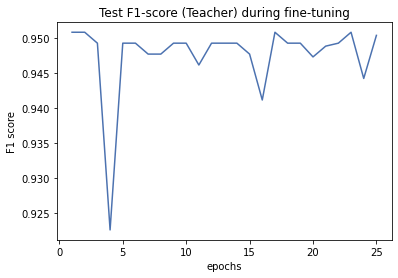

In [ ]:
# Plot the f1 socre vs. epochs curve
color_list = sns.color_palette('deep')
plt.plot(range(1,25+1),finalf1t,color = color_list[0])
plt.title('Test F1-score (Teacher) during fine-tuning')
plt.xlabel('epochs')
plt.ylabel('F1 score')


# Save the f1 score vs. epochs curve and data
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
plt.savefig('f1_score.jpg')
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
T_dict={'NUM_EPOCHS':25, 'f1_T':finalf1t}
savemat('f1_T.mat',T_dict)


In [117]:
# Train the student model
base_student,student_model = student()
ALPHA = 0.2
DISTILLATION_TEMPERATURE = 64
base_student.trainable = False
inif1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,10,1e-3)
#Fine-tuning
base_student.trainable = True
finf1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,25,1e-4)

Epoch 1: tf.Tensor(568.24, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(568.2369, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(568.2357, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(568.2354, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(568.2353, shape=(), dtype=float32)
0.8616803278688524
Epoch 6: tf.Tensor(568.2355, shape=(), dtype=float32)
0.8616803278688524
Epoch 7: tf.Tensor(568.2355, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(568.2357, shape=(), dtype=float32)
0.8616803278688524
Epoch 9: tf.Tensor(568.23584, shape=(), dtype=float32)
0.8616803278688524
Epoch 10: tf.Tensor(568.236, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(568.23456, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(568.2339, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(568.2337, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: 

KeyboardInterrupt: ignored

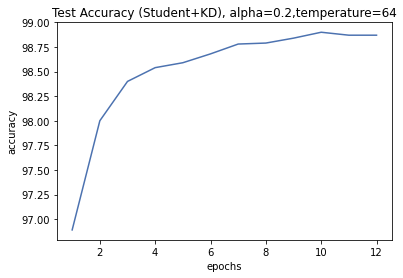

In [ ]:
# Plot the accuracy_S_KD vs. epochs curve
plt.plot(range(1,NUM_EPOCHS+1),accuracy_S_KD,color = color_list[0])
plt.title('Test Accuracy (Student+KD), alpha=0.2,temperature=64')
plt.xlabel('epochs')
plt.ylabel('accuracy')


# Save the accuracy_S_KD vs. epochs curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_KD.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_dict={'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_S_KD':accuracy_S_KD}
savemat('accuracy_S_KD.mat',S_KD_dict)


# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ACC = []
ALPHA = 0.5
temperatures = [1,2,4,16,32,64]
for temperature in temperatures:
  DISTILLATION_TEMPERATURE = temperature
  base_student,student_model = student()
  base_student.trainable = False
  inif1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,5,1e-2)
  #Fine-tuning
  base_student.trainable = True
  finf1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,5,1e-3)
  ACC.append(finf1[-1])
  print(ACC)
f1_S_KD = ACC

Epoch 1: tf.Tensor(0.5775972, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.57054925, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.656446, shape=(), dtype=float32)
0.8590753424657535
Epoch 4: tf.Tensor(0.57207036, shape=(), dtype=float32)
0.8500495968258032
Epoch 5: tf.Tensor(0.56609064, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(0.5488539, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.54883164, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.5488523, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.5489676, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(0.549314, shape=(), dtype=float32)
0.8616803278688524
[[]]
Epoch 1: tf.Tensor(1.5917735, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(1.5840875, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(1.6004571, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(1.6045243, s

In [ ]:
# Plot the accuracy_S vs. temperatures curve
log2_temperatures = [math.log2(x) for x in temperatures]
for i, temperature in enumerate(temperatures):
  plt.plot(log2_temperatures,f1_S_KD,color = color_list[0])
plt.title('Test Accuracy (Student+KD) vs. Temperature Hyperparameters')
plt.xlabel('log2(temperature)')
plt.ylabel('accuracy')

"""
# Save the accuracy_S curve vs. temperatures curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_KD__vs_Temp.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_dict={'temperatures':temperatures, 'accuracy_S_KD':accuracy_S_KD}
savemat('accuracy_S_KD_vs_Temp.mat',S_KD_dict)"""

# Test accuracy vs. alpha and tempreture curve

In [ ]:
ACC = []
temperatures = [1,2,4,16,32,64,128]
alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for alpha in alphas:
  for temperature in temperatures:
    ALPHA = alpha
    DISTILLATION_TEMPERATURE = temperature
    base_student,student_model = student()
    base_student.trainable = False
    inif1 = train_and_evaluate(base_student,student_model,compute_student_loss,10,1e-3)
    #Fine-tuning
    base_student.trainable = True
    finf1 = train_and_evaluate(base_student,student_model,compute_student_loss,25,1e-4)
    ACC.append(finf1[-1])
    print(ACC)
f1_S_KD_T_alpha = ACC

In [ ]:
# Plot the accuracy_S vs. alphas and temperatures curve
log2_temperatures = [math.log2(x) for x in temperatures]
for i, alpha in enumerate(alphas):
  plt.plot(log2_temperatures,f1_S_KD_T_alpha[i*7:(i+1)*7],color=color_list[i],label="alpha="+str(alpha))
  plt.legend()
plt.title('Test Accuracy (Student+KD) vs. alpha and T')
plt.xlabel('log2(temperature)')
plt.ylabel('accuracy')
"""
# Save the accuracy_S curve vs. alphas and temperatures curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_KD__vs_Temp_alpha.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_T_alpha_dict={'temperatures':temperatures,'alphas':alphas,'accuracy_S_KD_T_alpha':accuracy_S_KD_T_alpha}
savemat('accuracy_S_KD_vs_Temp_alpha.mat',S_KD_T_alpha_dict)"""

# Train student from scratch

In [ ]:
# Build fully connected student.
base_student_scratch = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
simgs = base_student_scratch.input
smidput = base_student_scratch(simgs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
smidput = keras.layers.GlobalAveragePooling2D()(smidput)
# A Dense classifier with a single unit (binary classification)
soutputs = Dense(2)(smidput)
student_model_scratch = keras.Model(simgs, soutputs)


#test {"output": "ignore"}

def compute_plain_cross_entropy_loss(base_student_scratch,student_model_scratch,images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = student_model_scratch(images, training=True)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,tf.nn.softmax(student_subclass_logits))
  
  return cross_entropy_loss

base_student_scratch.trainable = False
inif1_scratch = train_and_evaluate(base_student_scratch,student_model_scratch,compute_plain_cross_entropy_loss,10,1e-3)
#Fine-tuning
base_student_scratch.trainable = True
finf1_scratch = train_and_evaluate(base_student_scratch,student_model_scratch,compute_plain_cross_entropy_loss,10,1e-4)

Epoch 1: tf.Tensor(0.5320126, shape=(), dtype=float32)
0.9508196721311475
Epoch 2: 

KeyboardInterrupt: ignored

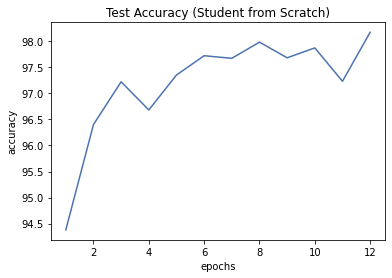

In [ ]:
# Plot the accuracy_S vs. epochs curve
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.plot(range(1,NUM_EPOCHS+1),accuracy_S,color=color_list[0])
plt.title('Test Accuracy (Student from Scratch)')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# Save the accuracy_S vs. epochs curve and data
plt.savefig('Test_Accuracy_S.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_dict = {'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_S':accuracy_S}
savemat('accuracy_S.mat',S_dict)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

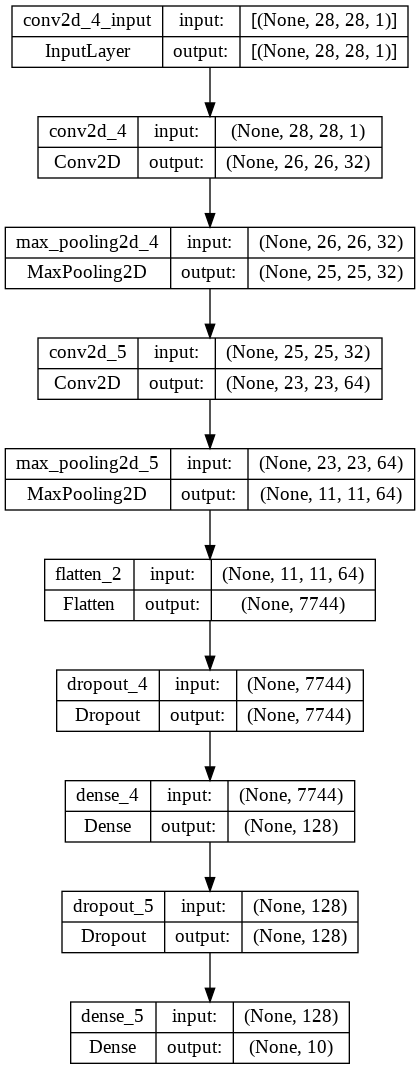

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 23, 23, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                    

In [ ]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 activation_3 (Activation)   (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 activation_4 (Activation)   (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
No

In [ ]:
fc_model_no_distillation.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 784)               615440    
                                                                 
 activation_9 (Activation)   (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 784)               615440    
                                                                 
 activation_10 (Activation)  (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
No

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12


# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
